In [15]:
# Install necessary packages if not already installed
# !pip install scanpy anndata igraph torch
# !pip install louvain

import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mpl_toolkits.mplot3d import Axes3D

### Single-Cell RNA Analysis with Scanpy and AnnData
This script processes single-cell RNA sequencing (scRNA-seq) data using Scanpy and AnnData. It reads an H5AD file, inspects the dataset's structure, and retrieves key attributes such as cell metadata, gene metadata, and UMAP embeddings for visualization.

In [3]:
# Set Pandas display options
pd.options.display.float_format = '{:.4f}'.format

# Load single-cell data from an H5AD file
adata = sc.read_h5ad("ad_worm_aging.h5ad")

# Display dataset dimensions
print(f"Number of observations (cells): {adata.n_obs}")
print(f"Number of variables (genes): {adata.n_vars}")
print(f"Data matrix type: {type(adata.X)}")

# Inspect cell metadata
print(f"Cell metadata entries: {len(adata.obs)}")

# Inspect gene metadata
print(f"Gene metadata entries: {len(adata.var)}")

# View available embeddings and transformations
print("Available obsm keys:", adata.obsm.keys())

# Display UMAP embedding shape and coordinates
if "X_umap" in adata.obsm:
    print(f"UMAP embedding shape: {adata.obsm['X_umap'].shape}")  # e.g., (5000, 2)
    print("UMAP coordinates:\n", adata.obsm["X_umap"])


Number of observations (cells): 47423
Number of variables (genes): 20305
Data matrix type: <class 'scipy.sparse._csr.csr_matrix'>
Cell metadata entries: 47423
Gene metadata entries: 20305
Available obsm keys: KeysView(AxisArrays with keys: X_umap, scvi)
UMAP embedding shape: (47423, 2)
UMAP coordinates:
 [[ 11.996049   -4.5285397]
 [ 11.966536   -4.5639434]
 [ 12.13793    -4.6060185]
 ...
 [  8.334566   -3.9024909]
 [ 14.051341   -5.063011 ]
 [  2.0279794 -14.025132 ]]


### Single-Cell RNA Analysis with Scanpy and AnnData
This script processes single-cell RNA sequencing (scRNA-seq) data using Scanpy and AnnData. It reads an H5AD file, inspects the dataset's structure, and retrieves key attributes such as cell metadata, gene metadata, and UMAP embeddings for visualization.

In [5]:
# Convert specific cell data to a DataFrame
cell_df = adata['TCTTGCGAGTCCTGCG-1-TC2_d11_1'].to_df()

# Filter cells based on metadata containing "pharyngeal neurons"
pharyngeal_neurons = adata.obs[adata.obs['annotate_name'].str.contains('pharyngeal neurons')]

### UNDERSTANDING METADATA INTERACTIONS ###

# Accessing cell metadata (annotations for individual cells)
print("Cell metadata columns:", adata.obs.columns)

# Accessing gene metadata (annotations for genes)
print("Gene metadata columns:", adata.var.columns)

# Ensuring alignment between metadata and the expression matrix
assert len(adata.obs) == adata.X.shape[0], "Mismatch in number of cells"
assert len(adata.var) == adata.X.shape[1], "Mismatch in number of genes"

### COMPUTING BASIC STATISTICS ###

# Display maximum transcript and gene counts per cell
print("Max transcripts in a single cell:", adata.obs["n_counts"].max())
print("Max genes detected in a single cell:", adata.obs["n_genes"].max())

# Count the number of unique genes
print("Unique genes in dataset:", adata.var["gene_ids"].nunique(), "\n")

### ANALYZING TRANSCRIPT REDUNDANCY ###

# Check if any cell has fewer total transcripts than the number of genes detected
count = 0

for idx, transcript_count in enumerate(adata.obs["n_counts"]):
    if int(transcript_count) < int(adata.obs["n_genes"][idx]):
        print(f"Cell {idx} has fewer transcripts than detected genes")
        count += 1

# Output the result of the redundancy check
if count == 0:
    print("Every cell has multiple transcripts for some genes")


Cell metadata columns: Index(['n_counts', 'n_genes', 'timepoint', 'annotate_name'], dtype='object')
Gene metadata columns: Index(['gene_ids', 'gene_names', 'gene_class', 'n_counts', 'n_cells'], dtype='object')
Max transcripts in a single cell: 109472.0
Max genes detected in a single cell: 4035
Unique genes in dataset: 20305 



C:\Users\marke\AppData\Local\Temp\ipykernel_29520\4260537935.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if int(transcript_count) < int(adata.obs["n_genes"][idx]):


Every cell has multiple transcripts for some genes


### Cell Type and Timepoint Analysis in Single-Cell Data
This script counts specific cell types (vulval muscle cells) across different timepoints in a single-cell RNA sequencing (scRNA-seq) dataset. It also identifies unique timepoints present in the dataset.

In [7]:
### TASK 1: Count Vulval Muscle Cells ###
vulval_muscle_count = adata.obs["annotate_name"].str.contains("vulval muscle").sum()
print("Total vulval muscle cell count:", vulval_muscle_count)

### BONUS ANALYSIS: Vulval Muscle Counts by Timepoint ###

# Count vulval muscle cells at timepoint d8
vulval_d8_count = adata.obs[adata.obs["timepoint"] == "d8"]["annotate_name"].str.contains("vulval muscle").sum()
print("Vulval muscle cells at day 8 (d8):", vulval_d8_count)

# Count vulval muscle cells at timepoint d11
vulval_d11_count = adata.obs[adata.obs["timepoint"] == "d11"]["annotate_name"].str.contains("vulval muscle").sum()
print("Vulval muscle cells at day 11 (d11):", vulval_d11_count)

# Identify and list all unique timepoints in the dataset
unique_timepoints = adata.obs["timepoint"].unique()
print("Unique timepoints in data:", list(unique_timepoints))


Total vulval muscle cell count: 605
Vulval muscle cells at day 8 (d8): 137
Vulval muscle cells at day 11 (d11): 50
Unique timepoints in data: ['d11', 'd15', 'd1', 'd3', 'd5', 'd8']


In [ ]:
### Preprocessing and Clustering of Single-Cell RNA Data with Scanpy
This script filters, preprocesses, and clusters single-cell RNA sequencing (scRNA-seq) data using Scanpy. It includes:

- Data filtering to remove low-quality cells and genes
- Principal Component Analysis (PCA) for dimensionality reduction
- Neighbor graph construction for cell similarity analysis
- Louvain clustering to group similar cells
- UMAP visualization for embedding the clustered cells in 2D space
- Statistical analysis of gene expression distributions

In [ ]:
### DATA PREPROCESSING ###

# Optional filtering of low-quality cells and genes (Uncomment to apply)
# sc.pp.filter_cells(adata, min_genes=200)  # Keep cells with at least 200 detected genes
# sc.pp.filter_genes(adata, min_cells=3)    # Keep genes detected in at least 3 cells

# Impute missing values in the data matrix
adata.X = np.nan_to_num(adata.X)

# Identify and remove cells and genes with zero variance
nonzero_cells = np.array(adata.X.sum(axis=1)).flatten() > 0  # Keep cells with non-zero expression
nonzero_genes = np.array(adata.X.sum(axis=0)).flatten() > 0  # Keep genes with non-zero expression

# Apply filtering
adata = adata[nonzero_cells, :]  # Filter cells
adata = adata[:, nonzero_genes]  # Filter genes

In [ ]:
### DIMENSIONALITY REDUCTION AND NEIGHBOR GRAPH CONSTRUCTION ###

# Perform Principal Component Analysis (PCA)
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')

# Print available cell embeddings
print("Cell embeddings (obsm keys):", adata.obsm.keys())

# Compute nearest neighbors graph using PCA representation
sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_pca")

# Print available cell-cell graph information
print("Cell-cell graph (obsp keys):", adata.obsp.keys())

In [ ]:
### CELL CLUSTERING AND VISUALIZATION (Alternative to Louvain) ###

# Perform Leiden clustering (alternative to Louvain)
sc.tl.leiden(adata, resolution=1)  # Leiden does not require the louvain package

# Compute UMAP embedding for visualization
sc.tl.umap(adata)

# Visualize UMAP with Leiden clustering
sc.pl.umap(adata, color="leiden")

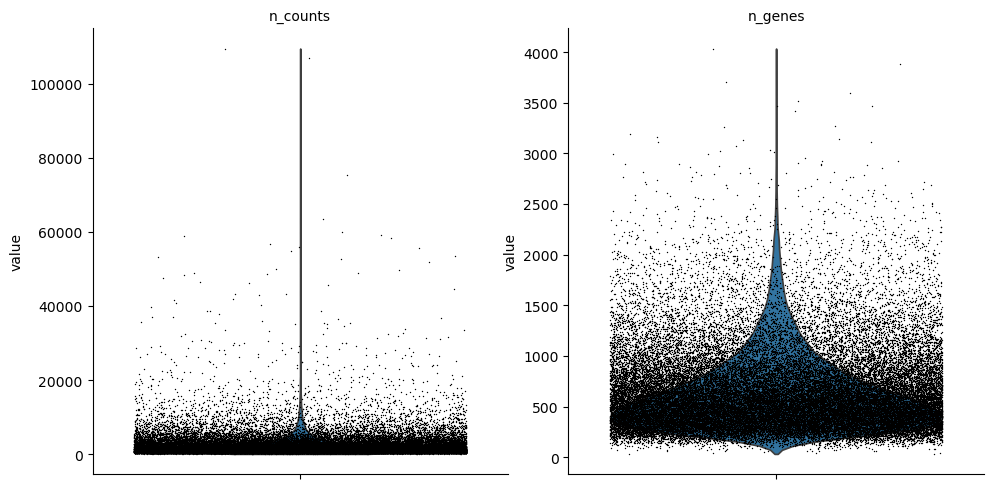

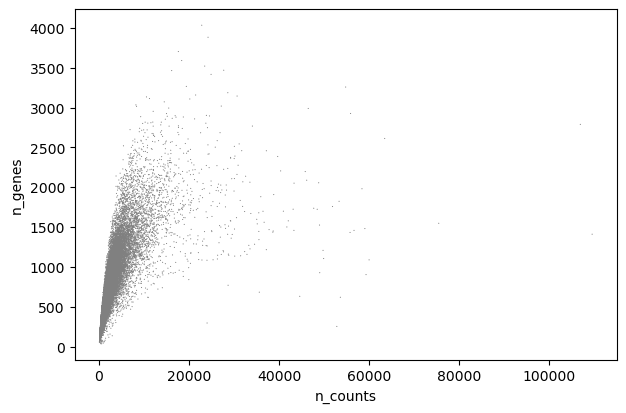

Gene confidence interval: 184 to 1765


In [13]:
### STATISTICAL ANALYSIS AND VISUALIZATION ###

# Violin plot of transcript and gene count distributions
sc.pl.violin(adata, ["n_counts", "n_genes"], jitter=0.4, multi_panel=True)

# Scatter plot of number of transcripts vs. number of genes per cella
sc.pl.scatter(adata, x="n_counts", y="n_genes")

# Compute 96% confidence interval for gene counts across cells
upper_lim = np.quantile(adata.obs.n_genes.values, 0.98)
lower_lim = np.quantile(adata.obs.n_genes.values, 0.02)
print(f"Gene confidence interval: {round(lower_lim)} to {round(upper_lim)}")